In [2]:
from abc import abstractmethod
from concurrent.futures.process import _process_worker
from lib2to3.pytree import Base
import os, sys
import gym
import time
import numpy as np
import text_flappy_bird_gym
from utils import argmax, plot_value_function
import matplotlib.pyplot as plt
import itertools

## Implementation des agents

In [3]:

class BaseAgent:
    def __init__(self, eps) : 
        self.obs = None
        self.eps = eps
        self.step_count = 0
        self.states = []
        self.actions = []
        self.rewards = []

        self.state_action_value_array = np.random.normal(size = (14, 25, 2))

        self.pi = np.random.uniform(low = 0, high = 1, size = (14, 25, 2))
        self.pi[:,:,0] = 1 - self.pi[:,:,1]

    def update_eps_greedy_policy(self):
        best_action = np.argmax(self.state_action_value_array, axis = 2)
        mask = (best_action == 0) #2D mask
        antimask = np.logical_not(mask) #2D
        mask = np.concatenate((mask[:,:,None], antimask[:,:,None]), axis = 2)
        self.pi[mask] = 1 - self.eps
        self.pi[np.logical_not(mask)] = self.eps 


    def policy(self, obs, save=True) : 
        x, y = obs
        if np.random.random() < self.pi[x, y , 0] : 
            action = 0
        else : 
            action = 1
        if save : 
            self.last_action = action
            self.obs = obs
        return action

    def get_reward(self, reward, next_obs, done):
        self.states.append(self.obs)
        self.actions.append(self.last_action)
        self.rewards.append(reward)
        self.next_obs = next_obs
        self.next_state_is_terminal = done
        self.step_count += 1 

    def reset_data(self) : 
        self.states = []
        self.rewards = []
        self.actions = []

    def update_episode(self) : 
        pass

    def update_step(self) : 
        pass
    
    def plot_q_function(self) : 
        V = {}
        for x in range(14) : 
            for y in range(-12, 13) : 
                for a, a_ in zip([False, True], [0,1]) : 
                    V[x, y, a] = self.state_action_value_array[x, y, a_]

        plot_value_function(V)
    
    def plot_pi(self) : 
        plt.figure()
        plt.title('policy probabilities for action 0 (Drop)')
        plt.imshow(self.pi[:,:,0])
        plt.colorbar()
        plt.show()

        plt.figure()
        plt.title('policy probabilities for action 1 (Jump)')
        plt.imshow(self.pi[:,:,1])
        plt.colorbar()
        plt.show()

In [4]:
class NoobAgent(BaseAgent):
    def __init__(self) : 
        super().__init__(0)

    def policy(self, obs) : 
        x, y = obs
        if y > -1 : 
            action =  1 
        else : 
            action =  0
        self.last_action = action
        return action

In [5]:

class EpsGreedyAgent(BaseAgent): 

    def __init__(self, eps = 0.1, learning_rate = None):
        super().__init__(eps)
        self.learning_rate = learning_rate
        self.state_action_count = np.zeros((14, 25, 2))

    def get_reward(self, reward, next_obs, done) : 
        self.reward = reward 

    def update_step(self) :
        x, y = self.obs
        self.state_action_count[x, y, self.last_action] += 1 
        if self.learning_rate is None : 
            learning_rate = 1/self.state_action_count[x, y, self.last_action]
        else : 
            learning_rate = self.learning_rate
        self.state_action_value_array[x, y, self.last_action] +=  learning_rate * (self.reward - self.state_action_value_array[x, y, self.last_action])
        self.update_eps_greedy_policy()

In [6]:

class MonteCarloESAgent(BaseAgent):

    def __init__(self, gamma = 0.9, eps = 0.1, eps_dr = 0.999):
        super().__init__(0)
        self.gamma = gamma
        self.eps = eps
        self.eps_dr = eps_dr
        self.points_removed = 0
        self.returns = self.init_returns()

    def init_returns(self) : 
        res = np.empty((14, 25, 2)).astype('object')
        for i in range(14) : 
            for j in range(25) :
                 res[i,j,0] = []
                 res[i,j,1] = []
        return res

    def update_episode(self) : 

        episode_list = list(zip(self.states, self.actions))
        episode_set = set(episode_list) 

        for (state, action) in episode_set: 
            first_occurence_idx = episode_list.index((state, action))

            G = sum([self.gamma**k * reward for (k, reward) in enumerate(self.rewards[first_occurence_idx:])])

            x, y = state
            self.returns[x, y, action].append(G)
            self.state_action_value_array[x, y, action] = np.mean(self.returns[x, y, action])
            best_action = argmax(self.state_action_value_array[x, y])

            self.pi[x, y, best_action] = 1 - self.eps
            self.pi[x, y, 1 - best_action] = self.eps

        self.reset_data()
        self.HP_update()
        
    def HP_update(self) : 
        self.eps *= self.eps_dr


In [7]:

class SarsaAgent(BaseAgent) : 
    def __init__(self, 
                eps = 0.1, 
                eps_dr = 0.999,
                alpha = 0.1, 
                alpha_dr = 0.999,
                gamma = .9) : 

        super().__init__(eps)
        self.eps = eps
        self.eps_dr = eps_dr
        self.alpha = alpha
        self.alpha_dr = alpha_dr
        self.gamma = gamma


    def update_step(self):
        reward = self.rewards[-1]
        x, y = self.obs
        x_, y_ = self.next_obs
        next_action = self.policy(self.next_obs, save=False) 
        
        Q = self.state_action_value_array[x, y, self.last_action]
        Q_ = self.state_action_value_array[x_, y_, next_action] #sarsa
        
        self.state_action_value_array[x, y, self.last_action] += self.alpha*(reward + self.gamma*Q_ - Q)

        # update policy
        self.update_eps_greedy_policy() 

    def HP_update(self) : 
        self.eps *= self.eps_dr
        self.alpha *= self.alpha_dr

    def update_episode(self):
        self.reset_data()
        self.HP_update()
     

In [8]:
      
class QueueLearningAgent(BaseAgent) : 
    def __init__(self, 
                eps = 0.1, 
                eps_dr = 0.999,
                alpha = 0.1, 
                alpha_dr = 0.999,
                gamma = .9) : 

        super().__init__(eps)
        self.eps = eps
        self.eps_dr = eps_dr
        self.alpha = alpha
        self.alpha_dr = alpha_dr
        self.gamma = gamma


    def update_step(self):
        reward = self.rewards[-1]
        x, y = self.obs
        x_, y_ = self.next_obs
        next_action = self.policy(self.next_obs, save=False) 
        
        Q = self.state_action_value_array[x, y, self.last_action]
        Q_ = np.max(self.state_action_value_array[x_, y_, :]) #queue learning
        
        self.state_action_value_array[x, y, self.last_action] += self.alpha*(reward + self.gamma*Q_ - Q)

        # update policy
        self.update_eps_greedy_policy() 

    def HP_update(self) : 
        self.eps *= self.eps_dr
        self.alpha *= self.alpha_dr

    def update_episode(self):
        self.reset_data()
        self.HP_update()

In [9]:

class nStepSarsaAgent(BaseAgent):
    def __init__(self, 
                n = 8, 
                eps = 0.1, 
                eps_dr = 0.999,
                alpha = 0.1, 
                alpha_dr = 0.999,
                gamma = .9) : 
                
        super().__init__(eps)
        self.n = n
        self.eps = eps
        self.eps_dr = eps_dr
        self.alpha = alpha
        self.alpha_dr = alpha_dr
        self.gamma = gamma

        #init policy
        self.update_eps_greedy_policy() 

    def update_step(self):

        if len(self.rewards) >= self.n : 
            rewards = self.rewards[-self.n: ]
            states = self.states[-self.n: ]
            actions = self.actions[-self.n: ]

            powers = np.arange(self.n)
            rewards = np.array(rewards)
            gammas = np.array([self.gamma]*self.n)
            G = (gammas**powers * rewards).sum()
            if not self.next_state_is_terminal : 
                x_, y_ = self.next_obs
                G += self.gamma ** self.n * self.state_action_value_array[x_, y_, self.policy(self.next_obs, save=False)] 

            # update state value function
            x, y = states[0]
            action = actions[0]
            self.state_action_value_array[x, y, action] += self.alpha * (G - self.state_action_value_array[x, y, action])

            # update policy
            best_action = np.argmax(self.state_action_value_array, axis = 2)
            mask = (best_action == 0) 
            antimask = np.logical_not(mask) 
            mask = np.concatenate((mask[:,:,None], antimask[:,:,None]), axis = 2)

            self.pi[mask] = 1 - self.eps
            self.pi[np.logical_not(mask)] = self.eps 

    def HP_update(self) : 
        self.eps *= self.eps_dr
        self.alpha *= self.alpha_dr

    def update_episode(self):
        self.reset_data()
        self.HP_update()



## Implementation de l'environnement d'entrainement

In [10]:
def train_agent(agent, env, n_iter, render = False, render_last_n_frames = 50, plot = False): 
    obs = env.reset()
    agent.obs = obs

    game_count = 0
    max_scores = []
    for it in range(n_iter) : 

        action = agent.policy(obs)  
        obs, reward, done, info = env.step(action)
        agent.get_reward(reward, obs, done)
        agent.update_step() # agent is learning here

        # Render the game
        if render and (it > n_iter - render_last_n_frames) : 
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.3)

        if done: 
            obs = env.reset()
            agent.update_episode() # agent is learning here
            game_count += 1
            max_scores.append(info['score'])

    env.close()

    if plot:
        plt.plot(np.arange(len(max_scores)), max_scores, 'x')
        plt.title(f'average score: {np.mean(max_scores):.2f}')
        plt.xlabel('game id')
        plt.ylabel('score')
        plt.show()
        agent.plot_pi()
        agent.plot_q_function()


def test_agent(agent, env, n_iter, render = False, render_last_n_frames = 50, plot = False):
    obs = env.reset()
    agent.obs = obs

    game_count = 0
    max_scores = []
    for it in range(n_iter) : 

        action = agent.policy(obs)  
        obs, reward, done, info = env.step(action)

        # Render the game
        if render and (it > n_iter - render_last_n_frames) : 
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.3)

        if done: 
            obs = env.reset()
            game_count += 1
            max_scores.append(info['score'])

    env.close()
    
    if plot:
        plt.plot(np.arange(len(max_scores)), max_scores, 'x')
        plt.title(f'average score: {np.mean(max_scores):.2f}')
        plt.xlabel('game id')
        plt.ylabel('score')
        plt.show()
        agent.plot_pi()
        agent.plot_q_function()
        
    return np.mean(max_scores)

In [11]:
# Train your agents here
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent = MonteCarloESAgent()

n_iter_train = 500000
n_iter_test = 5000
train_agent(agent, env, n_iter_train)
print('test score:', test_agent(agent, env, n_iter_test))

KeyboardInterrupt: 

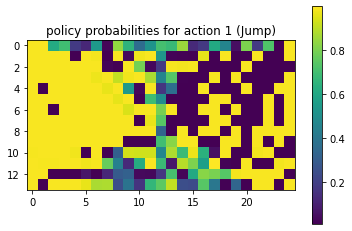

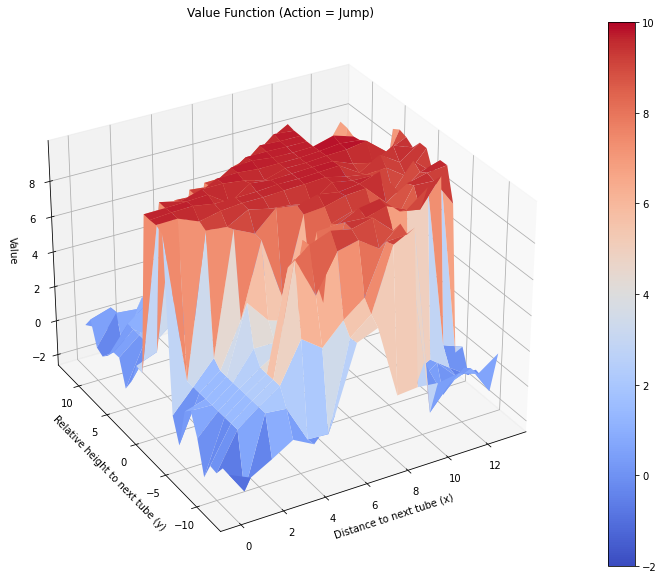

In [ ]:
#Q-function and policy insight : 
agent.plot_pi()
agent.plot_q_function()

## Recherche des hyperparamètres optimaux

In [ ]:
# Parameter grid search for MonteCarloESAgent
eps_ = [0.05, 0.1, 0.2]
r_eps_ = [0.99, 0.999]
gamma_ = [0.9]
n_repeat_training = 10
n_iter_train = 100000
n_iter_test = 1000

scores = {}
for eps, r_eps, gamma in itertools.product(eps_, r_eps_, gamma_) : 
    for _ in range(n_repeat_training):
        temp = []
        agent = MonteCarloESAgent(eps = eps, 
                                eps_dr = r_eps,
                                gamma = gamma)
        train_agent(agent, env, n_iter = n_iter_train)
        temp.append(test_agent(agent, env, n_iter = n_iter_test))
    scores[eps, r_eps, gamma] = np.mean(temp)

scores

{(0.05, 0.99, 0.9): 2.5,
 (0.05, 0.999, 0.9): 12.8,
 (0.1, 0.99, 0.9): 17.0,
 (0.1, 0.999, 0.9): 10.4,
 (0.2, 0.99, 0.9): 16.333333333333332,
 (0.2, 0.999, 0.9): 5.285714285714286}

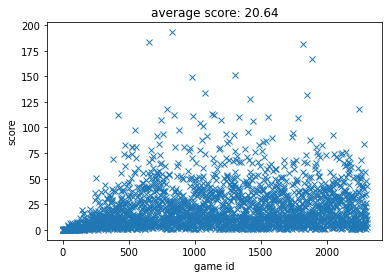

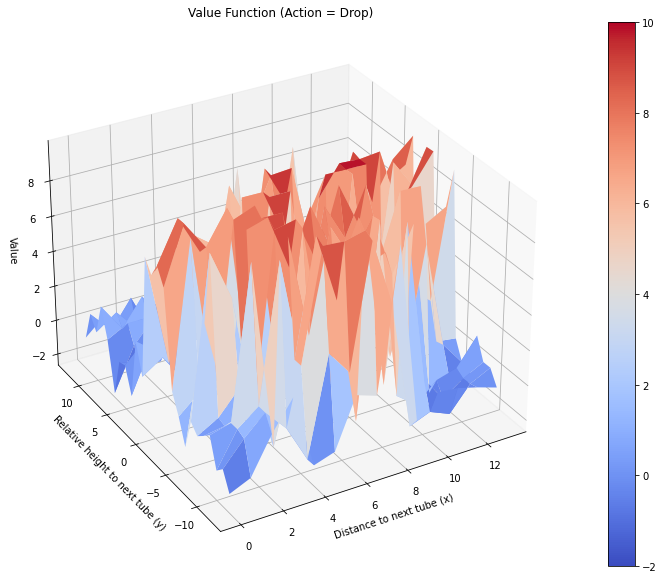

In [ ]:
# Vizualisation for the selected hypeparameters
eps, r_eps, gamma = max(scores, key = scores.get)


agent = MonteCarloESAgent(eps = eps, 
                          eps_dr = r_eps,
                          gamma = gamma)

train_agent(agent, env, n_iter = 500000, plot = True)

In [ ]:
# Parameter grid search for nStepSarsaAgent
eps_ = [0.1, 0.2]
r_eps_ = [0.99, 0.999]
gamma_ = [0.9]
alpha_ = [0.05, 0.1, 0.2]
r_alpha_ = [0.99, 0.999]
n_ = [4, 8, 12]
n_repeat_training = 10
n_iter_train = 100000
n_iter_test = 1000


scores = {}
for eps, r_eps, gamma, alpha, r_alpha, n in itertools.product(eps_, r_eps_, gamma_, alpha_, r_alpha_, n_) : 
    for _ in range(n_repeat_training):
        temp = []
        agent = nStepSarsaAgent(eps = eps, 
                                eps_dr = r_eps,
                                alpha = alpha, 
                                alpha_dr = r_alpha, 
                                gamma = gamma, 
                                n = n)
        train_agent(agent, env, n_iter = n_iter_train)
        temp.append(test_agent(agent, env, n_iter = n_iter_test))
    scores[eps, r_eps, gamma,alpha, r_alpha, n] = np.mean(temp)

NameError: name 'itertools' is not defined

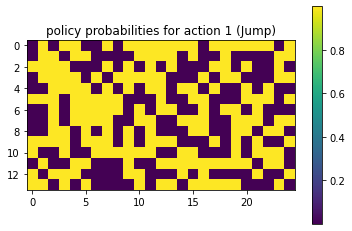

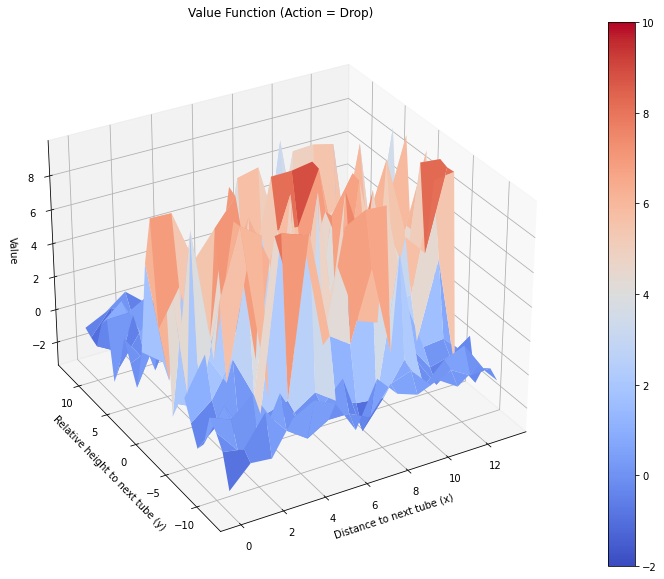

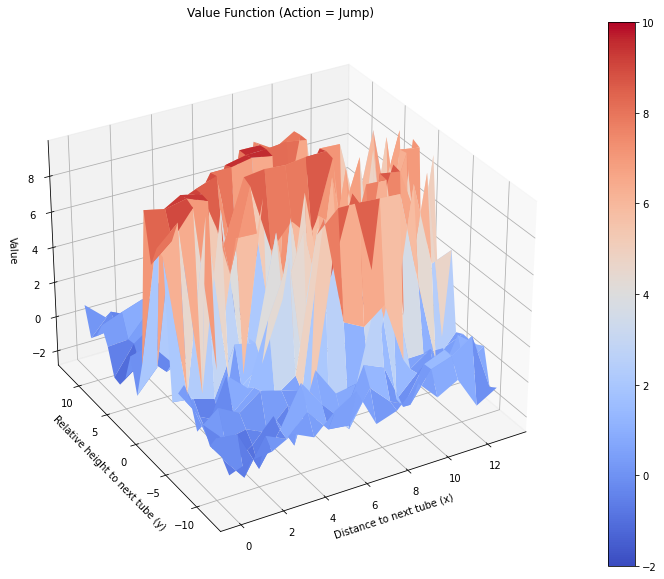

In [ ]:
# Vizualisation for the selected hypeparameters
eps, r_eps, gamma, alpha, r_alpha, n = max(scores, key = scores.get)


agent = nStepSarsaAgent(eps = eps, 
                        eps_dr = r_eps,
                        alpha = alpha, 
                        alpha_dr = r_alpha, 
                        gamma = gamma, 
                        n = n)

train_agent(agent, env, n_iter = 500000, plot = True)